In [2]:
from importlib import reload
# Tips to me:
# Use Python 3.11.6
# That's in the location /opt/homebrew/bin/python3

# Libraries
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import dataset_creator as dataset
from IPython.display import Audio
from Nets import complicatedNet
from torch.nn import functional as F
import models
from dotenv import load_dotenv


load_dotenv()

True

In [3]:
reload(dataset)
all_set = dataset.AudioDatasetAt("datasets/clipses", limit=20000)
trainset, testset, validationset = dataset.split_dataset(all_set, [0.9, 0.05, 0.1])
# testset = dataset.AudioDatasetAt("datasets/clips/test",limit=200)
# trainset = dataset.AudioDatasetAt("datasets/clips/train", limit=10000)
# validationset = dataset.AudioDatasetAt("datasets/clips/validation", limit=500)


In [4]:
reload(dataset)
# Check Loaders
from torch.utils.data import DataLoader
# trainloader = DataLoader(trainset, 32, shuffle=True, collate_fn=dataset.my_collater)
# validationloader = DataLoader(validationset, 8, shuffle=True, collate_fn=dataset.my_collater)
# testloader = DataLoader(testset, 8, shuffle=True, collate_fn=dataset.my_collater)
trainloader = DataLoader(trainset, 64, shuffle=True)
validationloader = DataLoader(validationset, 16, shuffle=True)
testloader = DataLoader(testset, 8, shuffle=True)

In [5]:
# Getting a random data
wf = all_set.get_random().unsqueeze(0)
inp = wf

print(inp.shape)
Audio(inp[0], rate=32000)

Getting 1286th item from the 20002 datasets.
torch.Size([1, 1, 96000])


In [6]:
# Instantiating a model
reload(complicatedNet)
reload(models)
from torch.optim import SGD, Adam

encoder = complicatedNet.Encoder(4)
quantizer = torch.nn.Identity()
decoder = complicatedNet.Decoder(4)
my_model = models.allNet(
    encoder=encoder, quantizer=quantizer, decoder=decoder
)
device = 'cpu'
my_model.to(device)
dummydata = torch.rand([np.random.randint(21),1,256]).to(device)
my_model.eval()
my_model.compile(backend="aot_eager")

my_model(dummydata)

lossfn = complicatedNet.LossFunction().to('cpu')
optimizer = SGD(my_model.parameters(), lr=0.1, weight_decay=0.97)
optimizer = Adam(my_model.parameters()) #, lr=0.1, weight_decay=0.97)

print(my_model)

/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
[2024-03-10 05:06:00,260] [0/0] torch._dynamo.output_graph: [WARNING] nn.Module forward/_pre hooks are only partially supported, and were detected in your model. In particular, if you do not change/remove hooks after calling .compile(), you can disregard this warning, and otherwise you may need to set torch._dynamo.config.skip_nnmodule_hook_guards=False to ensure recompiling after changing hooks.See https://pytorch.org/docs/master/compile/nn-module.html for more information and limitations. 
[2024-03-10 05:06:00,260] [0/0] torch._dynamo.output_graph: [WARNING] nn.Module state_dict and backward hooks are not yet supported by torch.compile, but were detected in your model and will be silently ignored. See https:/

allNet(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Down(
        (InConv): Conv1d(1, 4, kernel_size=(1,), stride=(1,))
        (Conv1): ConvolutionalStack(
          (ELU1): ELU(alpha=1.0)
          (Conv1): LazyCausalConv1d(
            (lazyLayer): Conv1d(4, 4, kernel_size=(11,), stride=(1,))
          )
          (BNorm1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (Conv2): ConvolutionalStack(
          (ELU1): ELU(alpha=1.0)
          (Conv1): LazyCausalConv1d(
            (lazyLayer): Conv1d(4, 4, kernel_size=(11,), stride=(1,), dilation=(2,))
          )
          (BNorm1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (Conv3): ConvolutionalStack(
          (ELU1): ELU(alpha=1.0)
          (Conv1): LazyCausalConv1d(
            (lazyLayer): Conv1d(4, 4, kernel_size=(11,), stride=(1,), dilation=(4,))
          )
          (BNorm1): BatchNorm1d(4, eps=1e-05, mom

In [7]:
torch._dynamo.list_backends()

['cudagraphs', 'inductor', 'onnxrt', 'openxla', 'openxla_eval', 'tvm']

In [8]:
x = inp.to(device)
my_model.eval()
output_bf = my_model(    x
    )[0].cpu().squeeze().unsqueeze(0).detach()

print(x.shape)
print(output_bf.shape)
print("Before Training, Model is :")
Audio(output_bf, rate=32000)


/opt/homebrew/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/opt/homebrew/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/opt/homebrew/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/opt/homebrew/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


torch.Size([1, 1, 96000])
torch.Size([1, 96000])
Before Training, Model is :


In [9]:
import model_trainer
reload(model_trainer)

statistics = model_trainer.train_and_validate(my_model, lossfn, optimizer, trainloader, validationloader, True, 15)

Training for 15 batches.

Batch 1:
Training step:
Forward propagating... 
Done. Time taken = 220.07311511039734
Back Propagating... 
Done. Time taken = 97.98619079589844
Saving statistics: Loss (avg) = 3.801974296569824

Validation step:
Forward propagating... 
Done. Time taken = 63.02418375015259
Saving statistics: Loss (avg) = 6.894441604614258


Batch 2:
Training step:
Forward propagating... 


In [ ]:
x = inp.to(device)
my_model.eval()
output_af = my_model(    x
    )[0].cpu().squeeze().unsqueeze(0).detach()

print(x.shape)
print(output_af.shape)
print("After Training, Model is :")
Audio(output_af, rate=32000)

torch.Size([8, 1, 96000])
torch.Size([1, 96000])
Before Training, Model is :


In [ ]:
reload(model_trainer)
model_trainer.save_model(my_model, "Spectral-And-Waveform-Net")

Saved model to models/Limited-Net/model_state_dict.pth


In [43]:
reload(model_trainer)
old_stats = model_trainer.retrieve_model(my_model, "models/Limited-Net")
print(old_stats)

x = inp.to(device)
my_model.eval()
output = my_model(    x
    )[0].cpu().squeeze().unsqueeze(0).detach()

print(x.shape)
print(output.shape)
print("After Training, Model is :")
Audio(output, rate=32000)

None
torch.Size([8, 1, 96000])
(1, 96000)
After Training, Model is :


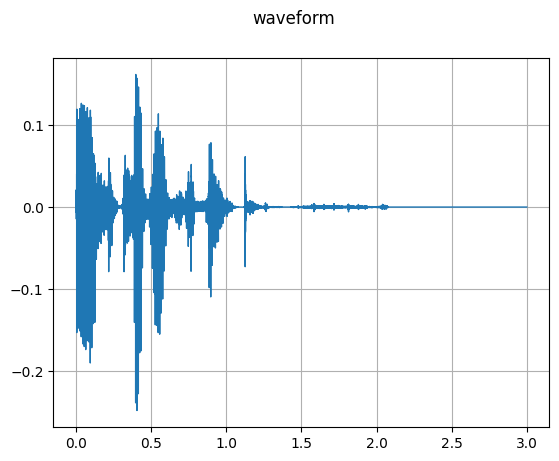

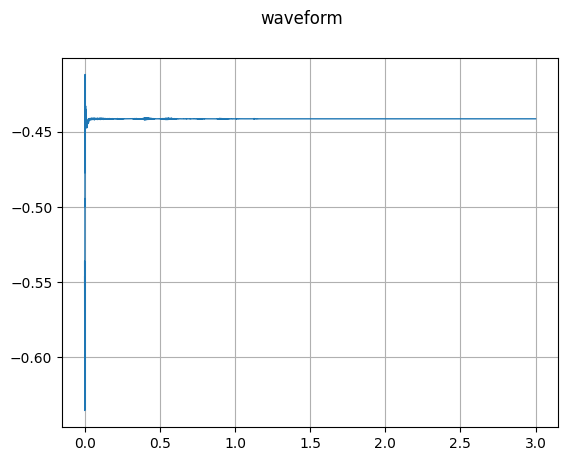

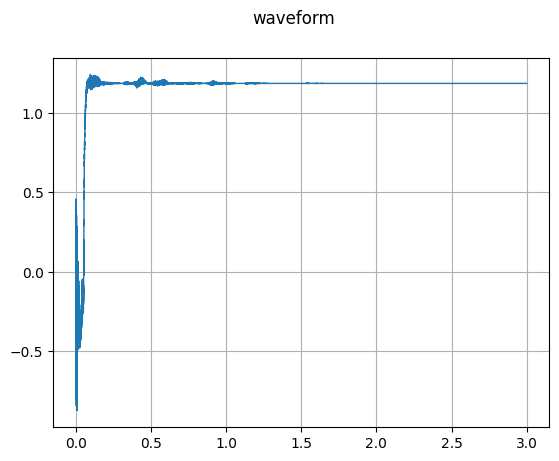

In [ ]:
from utilities.plotting import plot_waveform
plot_waveform(x[0], 32000)
plot_waveform(output_bf, 32000)
plot_waveform(output_af, 32000)

In [ ]:
spectrogramer1 = torchaudio.transforms.MelSpectrogram(32000)
spectrogramer2 = torchaudio.transforms.MelSpectrogram(32000)

In [ ]:
image1 = spectrogramer1(inp).cpu().detach()
image2 = spectrogramer1(out).cpu().detach()
image1 = F.interpolate(image1, scale_factor=.1, mode='bilinear').squeeze()
image2 = F.interpolate(image2, scale_factor=.1, mode='bilinear').squeeze()
# image1 = F.interpolate(image1, mode='linear', scale_factor=10).squeeze()
image1.shape, image2.shape

In [ ]:
plt.figure(figsize=(20,7))
plt.figure(211)
plt.imshow(image1)
plt.figure(212)
plt.imshow(image2)